In this notebook I fit rotation curve model from Brunetti & Pfenniger (2010) to the FGKM golden sample of the Gaia Data Release 3.
The paper can be found at: https://ui.adsabs.harvard.edu/abs/2010A%26A...510A..34B/abstract

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [2]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

KeyboardInterrupt: 

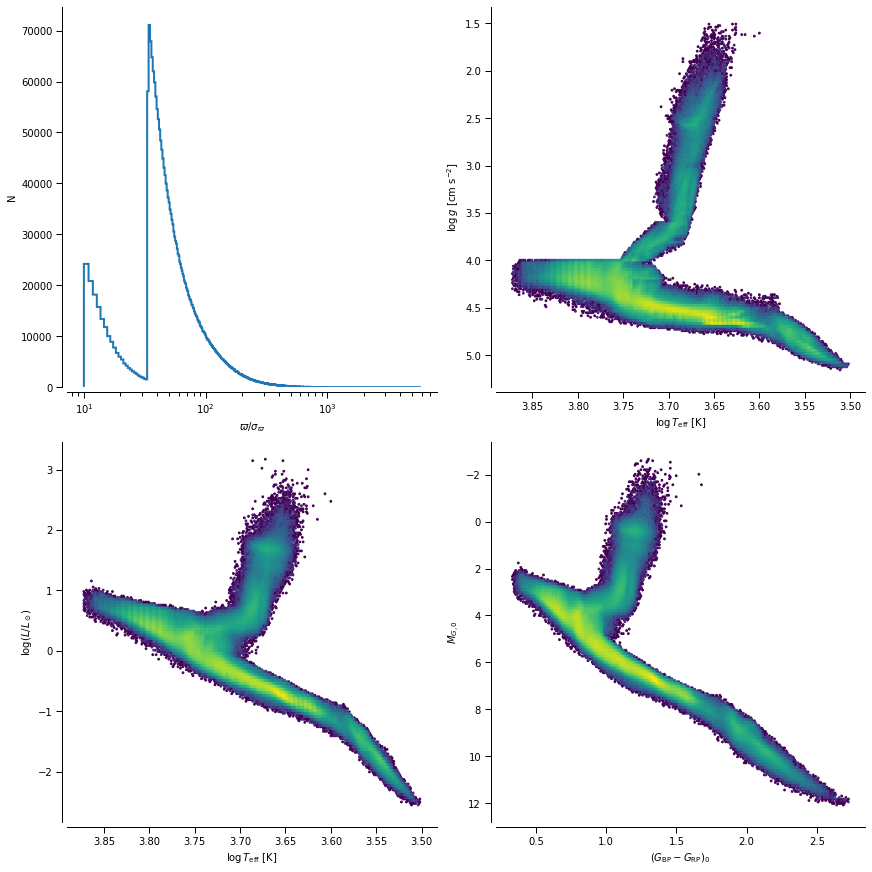

In [6]:
fig=plt.figure(constrained_layout=True, figsize=(2*6,2*6))

gs = GridSpec(2, 2, figure=fig)

axplxsnr = fig.add_subplot(gs[0,0])
apply_tufte(axplxsnr)

axplxsnr.hist(fgkmtable['parallax_over_error'], bins='auto', histtype='step', lw=2)
axplxsnr.set_xscale('log')
axplxsnr.set_xlabel(r'$\varpi/\sigma_\varpi$')
axplxsnr.set_ylabel('N')

axkiel = fig.add_subplot(gs[0,1])
apply_tufte(axkiel)
axkiel.hexbin(np.log10(fgkmtable['teff_gspphot']), fgkmtable['logg_gspphot'], bins='log', gridsize=200, mincnt=1)
axkiel.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
axkiel.set_ylabel(r'$\log g$ [cm s$^{-2}$]')
axkiel.invert_xaxis()
axkiel.invert_yaxis()
, gridsize=200
axhrd = fig.add_subplot(gs[1,0])
apply_tufte(axhrd)
axhrd.hexbin(np.log10(fgkmtable['teff_gspphot']), np.log10(fgkmtable['lum_flame']), bins='log', gridsize=200, mincnt=1)
axhrd.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
axhrd.set_ylabel(r'$\log(L/L_\odot)$')
axhrd.invert_xaxis()

axcmd = fig.add_subplot(gs[1,1])
apply_tufte(axcmd)
axcmd.hexbin(fgkmtable['bp_rp0_gspphot'], fgkmtable['mg_abs0_gspphot'], bins='log', gridsize=200, mincnt=1)
axcmd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_0$')
axcmd.set_ylabel(r'$M_{G,0}$')
axcmd.invert_yaxis()

plt.show()

Number of stars in selected sample: 23789


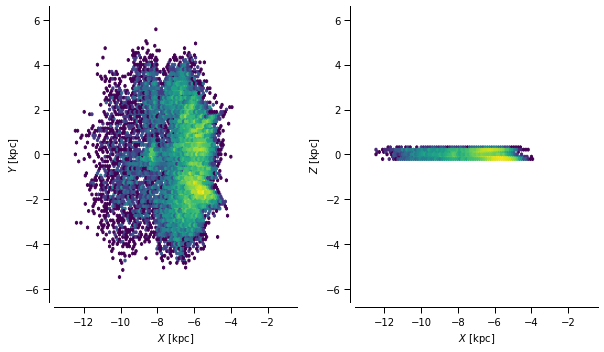

In [7]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

spt_lum_filter = giants

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

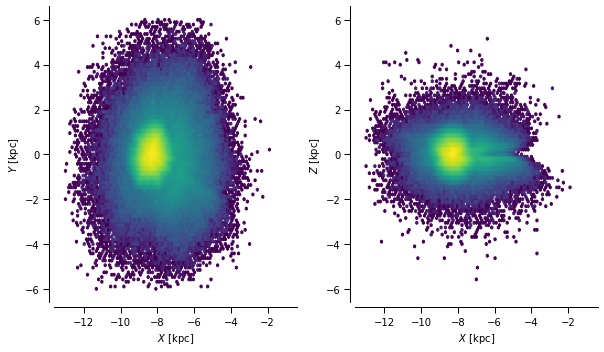

In [8]:
# Added 15-01-23
# Position-plot of the entire sample for comparison
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)


ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc']/1000, fgkmtable['y_gc']/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc']/1000, fgkmtable['z_gc']/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

Median d*sin(b): -74.5
RSE d*sin(b): 160.5
Mean d*sin(b): -33.7


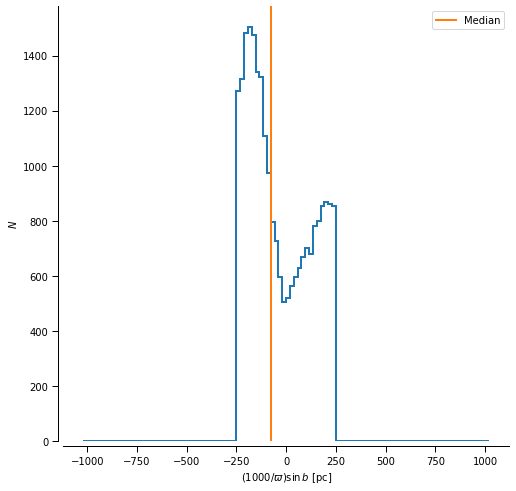

In [9]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

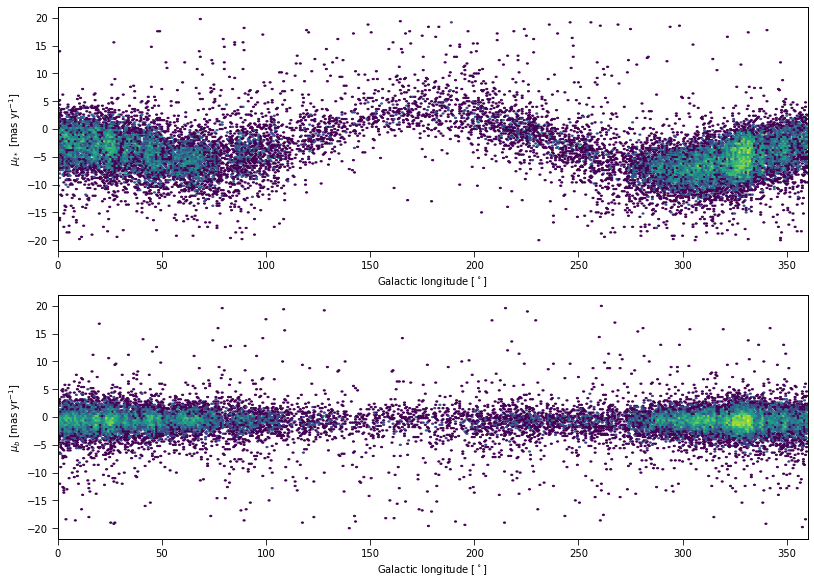

In [10]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

plt.savefig('fgkmstar-pml-pmb-vs-galon.png')

plt.show()

## Set up the Stan model

In [11]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()
    
declining_vcirc_disptens_model = {'stanfile':'mwdisk-declining-vcirc-disptens-model.stan', 
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
              }

declining_vcirc_disptens_rsunfree_model = {'stanfile':'mwdisk-declining-vcirc-disptens-rsunfree-model.stan', 
               'npars':8,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Rsun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$R_\odot$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Rsun':8.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Rsun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}
              }

# Added model: not used (Rsunfree) (is nu geen model file voor)
declining_vcirc_bp_rsunfree_model = {'stanfile':'rotcurve-bp.stan',
               'npars':8,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Rsun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$R_\odot$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Rsun':8.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Rsun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}
                }                     

# Added model
declining_vcirc_bp_model = {'stanfile':'rotcurve-bp.stan',
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}                                     
              }

stan_model = declining_vcirc_bp_model

distsunfree = False
if (stan_model['stanfile'] == 'mwdisk-declining-vcirc-disptens-rsunfree-model.stan'): # or declining_vcirc_bp_rsunfree_model
    distsunfree = True

Number of sources in sample: 3000


In [9]:
# p_param seems to be missing here. I'm keeping these cells untouched for the record.

print(os.getenv('HOME', "not found")) # Prints "not found"

fgkm_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
#set_cmdstan_path(os.path.join(os.getenv('HOME'), 'cmdstan')) # Does not work on windows
set_cmdstan_path(os.path.join('C:/Users/rjrri/.cmdstan/', 'cmdstan-2.31.0')) # Needs to be replaced with cmdstan location on other Windows devices
fgkm_data_path = os.path.join(os.getcwd(), 'fgkm.data.json')

nwarmup = 500
nsampling = 1000
nchains = 4

fgkm_model = CmdStanModel(stan_file=fgkm_stan)
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/')
fgkm_fit = fgkm_model.sample(show_console=False, chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=fgkm_data_path, save_warmup=False, show_progress='notebook', output_dir=fit_save_location)
#fgkm_fit = fgkm_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=fgkm_data_path, save_warmup=False, show_progress='notebook')


not found


21:43:18 - cmdstanpy - INFO - compiling stan file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\rotcurve-bp.stan to exe file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\rotcurve-bp.exe
21:43:54 - cmdstanpy - INFO - compiled model executable: C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\rotcurve-bp.exe
21:43:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:42:32 - cmdstanpy - INFO - CmdStan done processing.
22:42:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is -0.260894, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp.stan', line 193, column 2 to column 55)
	Exception: gamma_lpdf: Random variable is -1.47328, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp.stan', line 194, column 2 to column 54)
	Exception: gamma_lpdf: Random variable is -1.55711, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp.stan', line 194, column 2 to column 54)
	Exception: gamma_lpdf: Random variable is -0.547609, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp.stan', line 193, column 2 to column 55)
	Exception: gamma_lpdf: Random variable is -1.62133, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~

In [12]:
# Reading in earlier produced fits
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/')
fgkm_fit = from_csv(path=fit_save_location)

In [11]:
fgkm_fit.summary()[0:stan_model['npars']+2]
print(fgkm_fit)

CmdStanMCMC: model=rotcurve-bp chains=4['method=sample', 'num_samples=1000', 'num_warmup=500', 'thin=1', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\rotcurve-bp-20230207214355_1.csv
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\rotcurve-bp-20230207214355_2.csv
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\rotcurve-bp-20230207214355_3.csv
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\rotcurve-bp-20230207214355_4.csv
 output_files:
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\rotcurve-bp-20230207214355_0-stdout.txt
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\rotcurve-bp-20230207214355_1-stdout.txt
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-

In [13]:
summary = fgkm_fit.summary()[0:stan_model['npars']+3]
print(summary[0:stan_model['npars']+3])

                   Mean      MCSE     StdDev          5%          50%  \
lp__       -9626.590000  0.047767   2.093380 -9630.45000 -9626.270000   
Vcirc_sun     72.192400  0.397697  18.514300    41.10230    72.068700   
dVcirc_dVr    -0.160602  0.151440   9.746960   -16.01070    -0.265217   
Vsun_pec_x    22.901800  0.023814   1.527870    20.33650    22.909500   
Vsun_pec_y   -11.265400  0.397350  18.491200   -41.61510   -11.056100   
Vsun_pec_z     8.983050  0.006028   0.385413     8.33477     8.990570   
vdispxy       57.117800  0.010852   0.723716    55.94870    57.115100   
vdispz        20.786600  0.004181   0.276822    20.33230    20.783200   
h_param        1.957740  0.021970   1.374840     0.35305     1.625400   
p_param       -1.735910  0.018576   0.890858    -3.39588    -1.581490   

                    95%    N_Eff   N_Eff/s     R_hat  
lp__       -9623.750000  1920.64  0.235430  1.000500  
Vcirc_sun    102.847000  2167.26  0.265660  1.000200  
dVcirc_dVr    15.810000  4142.4

In [ ]:
# Input for command line of rotcurve-bp.py:
python rotcurve-bp.py -b --pexp -1.58 --scalelength 1.63 --vcsun 72.07
# rsun not filled in

In [13]:
fgkm_fit.diagnose()

'Processing csv files: C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\rotcurve-bp-20230207214355_1.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\rotcurve-bp-20230207214355_2.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\rotcurve-bp-20230207214355_3.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\rotcurve-bp-20230207214355_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

Vcirc_sun = 72.1+18.6-18.0
dVcirc_dVr = -0.3+9.9-9.7
Vsun_pec_x = 22.9+1.5-1.5
Vsun_pec_y = -11.1+18.0-18.9
Vsun_pec_z = 9.0+0.4-0.4
vdispxy = 57.1+0.7-0.7
vdispz = 20.8+0.3-0.3


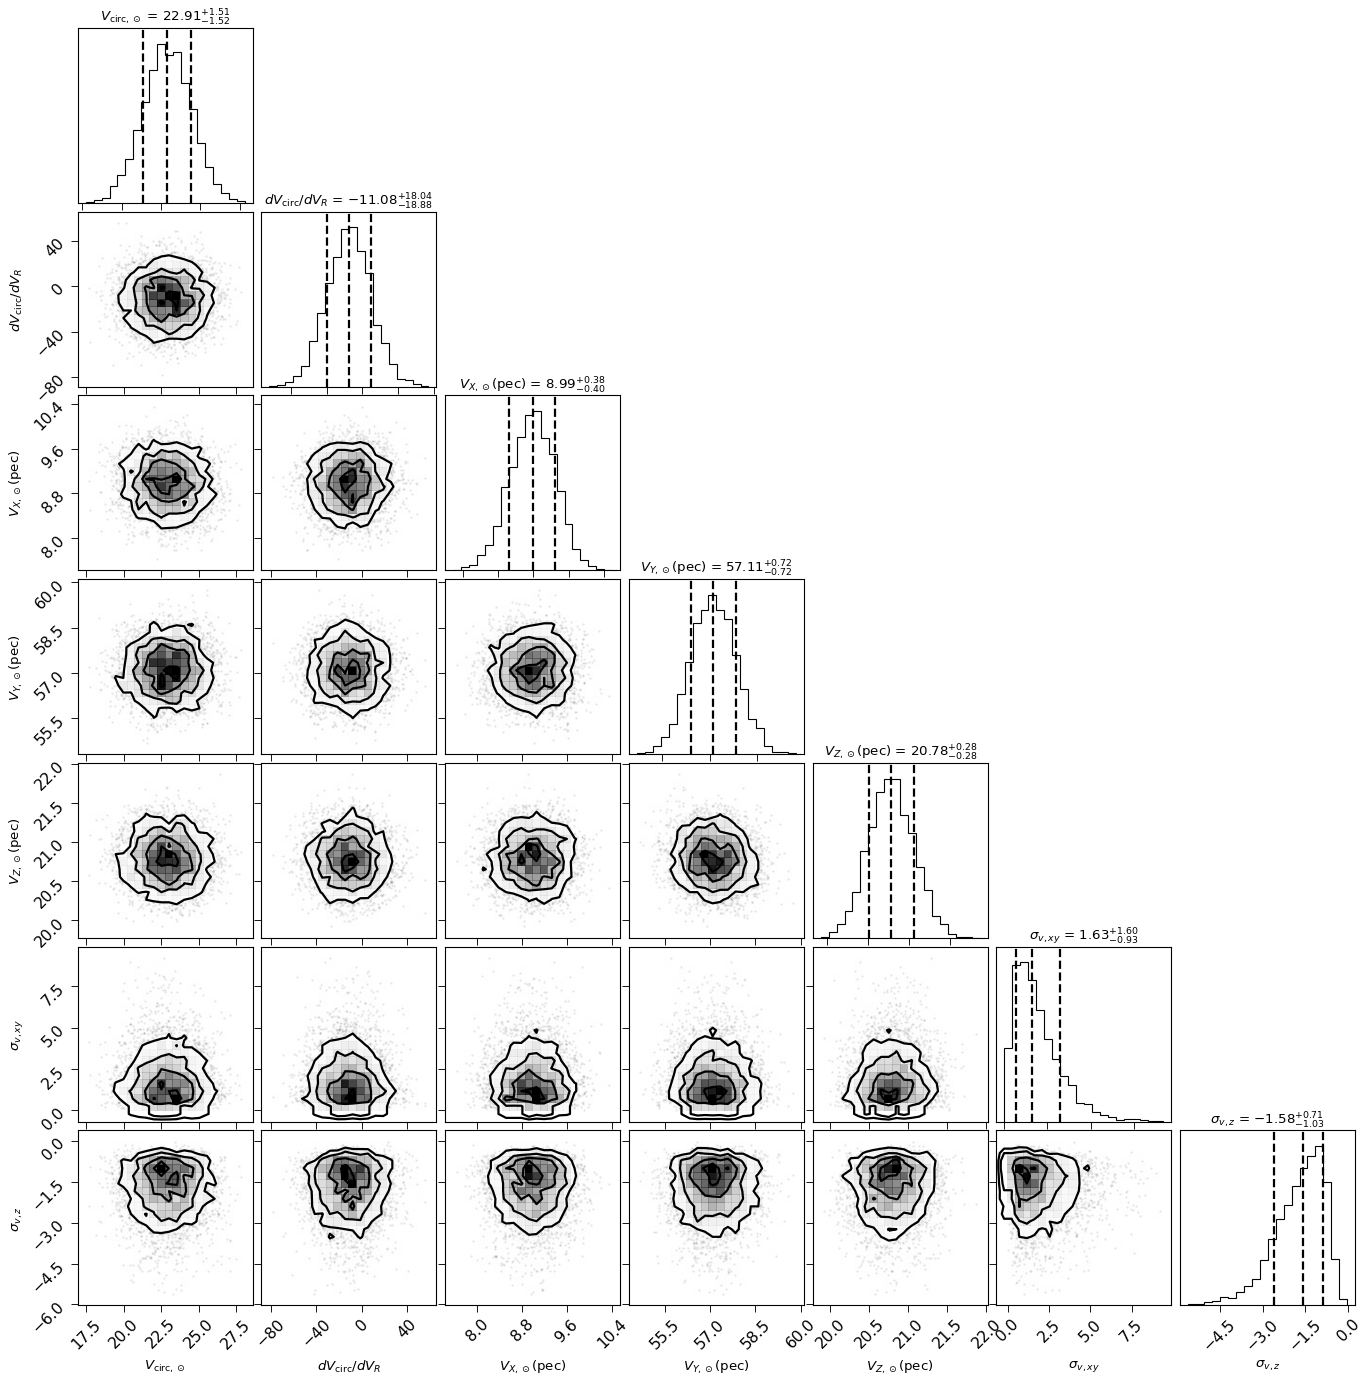

In [14]:
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(9, 9+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()
# Kijken of dit zo werkt? 